The purpose of this section of the capstone project is to model the car data that has been prepared and determine which model would perform best as a predictor of car price.  To recap, the following variables have all been show to be statistically significant in affecting car price, and so they will all be taken into account in the models:

Year <br>
Manufacturer <br>
Number of Cylinders <br>
Odometer <br>
Transmission <br>
Drive <br>
Paint Color <br>
State

In the previous part of the project, the data had already been put into training (%70) and testing sets(%30), and dummy variables have been assigned to all of the categorical variables, so all that is left to do is model the data.  The three models that I am using are Random Forest, AdaBoost, and Gradient Boosting.  They are all three ensemble methods that all use trees to split data, which is useful since I did not scale the data.

Since this is a regression model, I am ranking the performance of the data on three key factors, root mean squared error, mean absolute error and adjusted r squared.  These are commonly accepted as among the most important factors in determining model effectiveness for regression.  I am also taking into account the time it takes to fit each model, which could be a big factor if someone wants quick results.

First I will import any models that I might use.  I will likely not use all of them.

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import statsmodels.api as sm
import time

Now to import the data and look at it to make sure it is ready to model.

In [2]:
cars = pd.read_csv('cars.csv', index_col=0)
X_train = pd.read_csv('cars_x_train.csv', index_col=0)
X_test = pd.read_csv('cars_x_test.csv', index_col=0)
y_train = pd.read_csv('cars_y_train.csv', index_col=0)
y_test = pd.read_csv('cars_y_test.csv', index_col=0)

cars.head()

,id,price,year,manufacturer,model,cylinders,odometer,transmission,drive,paint_color,state
1,7184773187,8750,2013.0,hyundai,sonata,4 cylinders,90821.0,automatic,fwd,grey,MN
2,7193375964,10900,2013.0,toyota,prius,4 cylinders,92800.0,automatic,fwd,blue,CT
6,7184710887,7995,2010.0,chevrolet,equinox,4 cylinders,108124.0,automatic,4wd,grey,MN
14,7184705759,10995,2008.0,chevrolet,tahoe,Unknown,143528.0,automatic,4wd,grey,MN
17,7184703651,14995,2011.0,chevrolet,silverado 1500,8 cylinders,102462.0,automatic,4wd,blue,MN


In [3]:
X_train.shape, X_test.shape

((128459, 118), (55055, 119))

I immediately notice a small problem.  The column sizes are different, which means there is a variable in the test set that is not in the training set.  I need to determine what it is.

In [4]:
set(X_test.columns).difference(X_train.columns)

{'morgan'}

I did research and found out this was indeed a car type.  However, the model would not run on the training set because the number of columns are different.  I will have to drop this column to make sure they are the same.

In [5]:
X_test = X_test.drop('morgan',axis=1)
X_train.shape, X_test.shape

((128459, 118), (55055, 118))

In [6]:
y_train.shape, y_test.shape

((128459, 1), (55055, 1))

Now it's time for modeling <br>
I want to run cross validation on all the training sets to get an idea of the best hyperparameters that I can use the maximize the effectiveness of my model.  For each of my models, I will use GridSearchCV for this, and I will pick three hyperparameters that are often accepted as the most important, as well as three options for each hyperparameter.


The first model I will use Random Forest<br> 
The three hyperparameters I will focus on are: <br>
n_estimators-number of trees in the forest<br>
max_features- max number of features considered for splitting a node<br>
max_depth- max number of levels in each decision tree.  

In [7]:
rf = RandomForestRegressor()
param = {'n_estimators':[100,150,200],'max_depth':[30,60,90], 'max_features':[7,9,11]}
gs = GridSearchCV(rf, param, cv=3, n_jobs=-1)
gs.fit(X_train,y_train)

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [30, 60, 90], 'max_features': [7, 9, 11],
                         'n_estimators': [100, 150, 200]})

In [8]:
gs.best_params_

{'max_depth': 60, 'max_features': 11, 'n_estimators': 200}

From the options I gave, the model determined that the best hyperparameters are a max depth of 60, 9 max features, and 200 estimators.  I will now use these to fit and train my model, also timing to see how long it takes to predict on new models.

In [9]:
rfr = RandomForestRegressor(n_estimators=200, max_depth=60,max_features=11)
model_res = rfr.fit(X_train, y_train)
startrf=time.time()
y_pred = model_res.predict(X_test)
endrf=time.time()
rf_pred_time = (endrf-startrf)
rf_pred_time

<ipython-input-9-82d7921e191b>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_res = rfr.fit(X_train, y_train)


5.117738485336304

In [81]:
rf_time = rf_pred_time/len(X_test)*100
rf_time

0.009295683380866959

The time that it would take to fit 100 vehicle samples is 0.009 seconds.  I picked this value to get an idea of time it would take if a company was testing many cars at a time.  Now I will compare the predicted y values to the actual y values using root mean squared error and mean absolute error.  I will also find the adjusted r squared.  To do this I need to find the r squared then put it in the formula for determining adjusted r squared.  I will come back to this information after I ran all of my models to compare.

In [62]:
importance_rf = model_res.feature_importances_
for i,v in enumerate(importance_rf):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.24592
Feature: 1, Score: 0.23322
Feature: 2, Score: 0.00014
Feature: 3, Score: 0.00080
Feature: 4, Score: 0.00343
Feature: 5, Score: 0.00327
Feature: 6, Score: 0.00128
Feature: 7, Score: 0.00407
Feature: 8, Score: 0.00761
Feature: 9, Score: 0.00215
Feature: 10, Score: 0.00002
Feature: 11, Score: 0.00461
Feature: 12, Score: 0.00527
Feature: 13, Score: 0.00039
Feature: 14, Score: 0.01170
Feature: 15, Score: 0.01009
Feature: 16, Score: 0.00018
Feature: 17, Score: 0.00345
Feature: 18, Score: 0.00492
Feature: 19, Score: 0.00091
Feature: 20, Score: 0.00130
Feature: 21, Score: 0.00417
Feature: 22, Score: 0.00386
Feature: 23, Score: 0.00003
Feature: 24, Score: 0.00174
Feature: 25, Score: 0.00154
Feature: 26, Score: 0.00109
Feature: 27, Score: 0.00618
Feature: 28, Score: 0.00093
Feature: 29, Score: 0.00037
Feature: 30, Score: 0.00182
Feature: 31, Score: 0.00716
Feature: 32, Score: 0.00073
Feature: 33, Score: 0.00010
Feature: 34, Score: 0.01675
Feature: 35, Score: 0.00237
Fe

It's nice to see how every feature's importance was used, and I know feature 0 was year, and feature 1 was odometer, and those look to be by far the most important.  However, I am not sure what all of the other features are, and it is tedius to scroll through and find the highest features.  It would help to visualize it.  I'm going to look at the top 15 for this and label them.

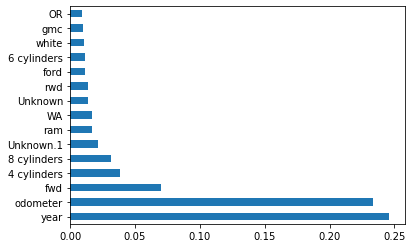

In [63]:
feat_importances_rf = pd.Series(model_res.feature_importances_, index=X_train.columns)
feat_importances_rf.nlargest(15).plot(kind='barh')

I used pd.options.display.max_columns equal to None so I could look at all of the dataframe columns at the same time(I'm not going to put it here to save space). I wanted to find out what Unknown and Unknown.1 represented.  Unknown.1 referred to drive, and Unknown referred to number of cylinders.  I was not surprised that year and odometer were by far the biggest factors that the model used, so I feel like the model did well.  Drive and number of cylinders were the next biggest factors, and then it gets closer.  It looks like being a west coast state could be a factor as well.

Now I will compare the predicted y values to the actual y values using root mean squared error and mean absolute error.  I will also find the adjusted r squared.  To do this I need to find the r squared then put it in the formula for determining adjusted r squared.  I will come back to this information after I ran all of my models to compare.

In [10]:
rand_for_rmse = sqrt(mean_squared_error(y_test,y_pred))
rand_for_rmse

5282.472640585916

In [11]:
rand_for_mae = mean_absolute_error(y_test,y_pred)
rand_for_mae

2821.281130815781

In [12]:
rand_for_rsq = r2_score(y_test,y_pred)
rand_for_rsq

0.8294313627975076

In [13]:
rand_for_adjrsq = (1-(1-rand_for_rsq)*((len(X_test)-1)/(len(X_test)-9-1)))
rand_for_adjrsq

0.8294034743837585

The next model I will use is Adaboost<br>
The three hyperparameters I will focus on are: <br>
n_estimators - The maximum number of estimators at which boosting is terminated<br>
learning-rate - shrinks the contribution of each classifier by learning_rate<br>
loss - the loss function to use when updating the weights after each boosting iteration.

I will follow all of the same procedures as the previous model.

In [14]:
ar = AdaBoostRegressor()
param_ada = {
 'n_estimators': [25, 50, 75],
 'learning_rate' : [0.01,0.05,0.1],
 'loss' : ['linear', 'square', 'exponential']
 }
gsa = GridSearchCV(ar, param_ada, cv=3, n_jobs=-1)
gsa.fit(X_train,y_train)

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=3, estimator=AdaBoostRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [25, 50, 75]})

In [15]:
gsa.best_params_

{'learning_rate': 0.05, 'loss': 'exponential', 'n_estimators': 50}

From the options I gave, the model determined that the best hyperparameters are a learning rate of 0.05, an exponential loss function, and 50 estimators.  I will now use these to fit and train my model, also timing to see how long it takes to predict on new models.

In [16]:
abr = AdaBoostRegressor(n_estimators=50,learning_rate=0.05,loss="exponential")
modelada= abr.fit(X_train, y_train)
startab=time.time()
y_pred_ab = modelada.predict(X_test)
endab=time.time()
ab_pred_time = (endab-startab)
ab_pred_time

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1.4640848636627197

In [74]:
ab_time = ab_pred_time/len(X_test)*100
ab_time

0.0026593131662205425

The time taken for 100 vehicles was 0.0027 seconds. These values are small, so time would only be a factor for large datasets, and it would not affect individual sellers.  

I want to look at the feature importance again.  I want to look at all the features again and then make a graph to see the most important.

In [57]:
importance_ab = modelada.feature_importances_
for i,v in enumerate(importance_ab):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.38485
Feature: 1, Score: 0.29475
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00442
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

I should have realized that this modeling technique eliminates the less important features, so there are a lot of zeroes.  I will graph to see what the most important features are.

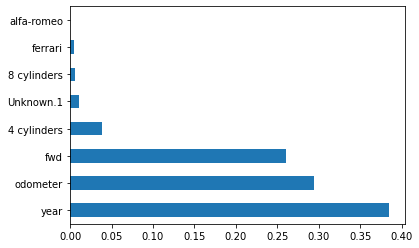

In [61]:
feat_importances_ab = pd.Series(modelada.feature_importances_, index=X_train.columns)
feat_importances_ab.nlargest(8).plot(kind='barh')

Odometer and year are not surprising, but I thought it was interesting that being front wheel drive is close to mileage, and those three factors make up over 95% of the predicting. Cylinders is the next most important, with a little importance also being given to if the vehicle is a ferrari.  I am curious if the unknown type of drive is a factor because there are so many.

In [78]:
cars['drive'].value_counts()

fwd        59536
4wd        59343
Unknown    41463
rwd        23172
Name: drive, dtype: int64

It is a large amount, but not overwhelming. The only factor that is not accounted for is all wheel drive.  That actually might be important, however it is impossible to tell which one of these unknown values actually represent all wheel drive.  I would predict that it could be a large amount.

I will calculate rmse, mae, and adjusted r squared as before. I will come back to this information after I ran all of my models to compare.

In [17]:
ab_rmse = sqrt(mean_squared_error(y_test,y_pred_ab))
ab_rmse

9372.27901803016

In [18]:
ab_mae = mean_absolute_error(y_test,y_pred_ab)
ab_mae

6517.008656546293

In [19]:
ab_rsq = r2_score(y_test,y_pred_ab)
ab_rsq

0.4630731954839079

In [20]:
ab_adjrsq = (1-(1-ab_rsq)*((len(X_test)-1)/(len(X_test)-9-1)))
ab_adjrsq

0.4629854065613783

The final model that I will use is Gradient Boosting<br>
The three hyperparameters that I will focus on are:<br>
n_estimators - the number of boosting stages to perform<br>
learning_rate - shrinks the contribution of each tree by learning_rate<br>
max_depth - maximum depth of the individual regression estimators

I will follow the same procedure as with the previous models.

In [21]:
gb = GradientBoostingRegressor()
param_gb = {
    'n_estimators':[150,200,250],
    'learning_rate':[0.1,0.25,0.5],
    'max_depth':[6,8,10]
}
gsg = GridSearchCV(gb, param_gb, cv=3, n_jobs=-1)
gsg.fit(X_train,y_train)

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.25, 0.5],
                         'max_depth': [6, 8, 10],
                         'n_estimators': [150, 200, 250]})

In [22]:
gsg.best_params_

{'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 250}

From the options I gave, the model determined that the best hyperparameters are a learning rate of 0.1, a max depth of 6, and 200 estimators.  I will now use these to fit and train my model, also timing to see how long it takes to predict on new models.

In [32]:
gbr = GradientBoostingRegressor(learning_rate=0.25,max_depth=10,n_estimators=250)
model_gb = gbr.fit(X_train,y_train)
startgb = time.time()
y_pred_gb = model_gb.predict(X_test)
endgb = time.time()
gb_pred_time = (endgb - startgb)
gb_pred_time

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.9644227027893066

In [79]:
gb_time = gb_pred_time/len(X_test)*100
gb_time

0.0017517440791741108

The time taken was 0.0018 seconds.  I will look at feature importance.

In [55]:
importance_gb = model_gb.feature_importances_
for i,v in enumerate(importance_gb):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.35090
Feature: 1, Score: 0.14714
Feature: 2, Score: 0.00009
Feature: 3, Score: 0.00091
Feature: 4, Score: 0.00310
Feature: 5, Score: 0.00286
Feature: 6, Score: 0.00051
Feature: 7, Score: 0.00482
Feature: 8, Score: 0.00639
Feature: 9, Score: 0.00080
Feature: 10, Score: 0.00006
Feature: 11, Score: 0.00324
Feature: 12, Score: 0.00675
Feature: 13, Score: 0.00031
Feature: 14, Score: 0.01249
Feature: 15, Score: 0.00815
Feature: 16, Score: 0.00019
Feature: 17, Score: 0.00207
Feature: 18, Score: 0.00287
Feature: 19, Score: 0.00057
Feature: 20, Score: 0.00128
Feature: 21, Score: 0.00560
Feature: 22, Score: 0.00203
Feature: 23, Score: 0.00003
Feature: 24, Score: 0.00167
Feature: 25, Score: 0.00092
Feature: 26, Score: 0.00040
Feature: 27, Score: 0.00826
Feature: 28, Score: 0.00056
Feature: 29, Score: 0.00018
Feature: 30, Score: 0.00248
Feature: 31, Score: 0.00611
Feature: 32, Score: 0.00019
Feature: 33, Score: 0.00012
Feature: 34, Score: 0.01362
Feature: 35, Score: 0.00218
Fe

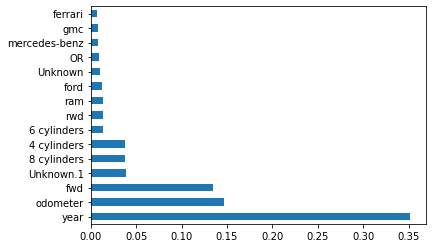

In [56]:
feat_importances_gb = pd.Series(model_gb.feature_importances_, index=X_train.columns)
feat_importances_gb.nlargest(15).plot(kind='barh')

The general order of everything was similar to the others, with the same top three in order.  However, year was a much bigger contributor to the model, making up over a third of the model feature importance.  Odometer and front wheel drive were the close, followed by cylinders.  Overall, year, mileage, drive, and number of cylinders played easily the most substantial factor in each model.

In [33]:
gb_rmse = sqrt(mean_squared_error(y_test,y_pred_gb))
gb_rmse

5629.438763598316

In [34]:
gb_mae = mean_absolute_error(y_test,y_pred_gb)
rand_for_mae

2821.281130815781

In [35]:
gb_rsq = r2_score(y_test,y_pred_gb)
gb_rsq

0.8062887402933393

In [36]:
gb_adjrsq = (1-(1-gb_rsq)*((len(X_test)-1)/(len(X_test)-9-1)))
gb_adjrsq

0.8062570680008994

It is now time to compare my results.  There were not many data points that we were using, but it is still nice to see them graphically.  The first thing I will compare is the time it took for each model to make a prediction.  This could be an important factor if companies are wanting fast results.

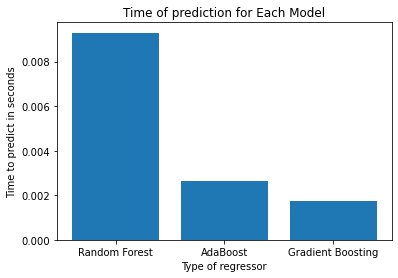

In [82]:
all_times = [rf_time, ab_time, gb_time]
labels = ['Random Forest', 'AdaBoost', 'Gradient Boosting']
fig,ax = plt.subplots()
time_bar = ax.bar(labels,all_times)
ax.set_xlabel('Type of regressor')
ax.set_ylabel('Time to predict in seconds')
ax.set_title('Time of prediction for Each Model')
plt.show()

The time difference between random forest and the two boosting models was noticable, but it is important to take into account that these are few low times.  Unless the amount of data is extremely large, time would not play a big factor.

Now we will compare the square root of the error of each model.  A lower score means that the predictions were closer to the actual values.

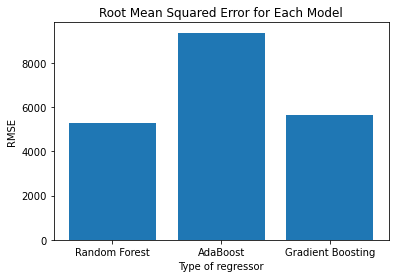

In [83]:
all_rmse = [rand_for_rmse, ab_rmse, gb_rmse]
fig,ax = plt.subplots()
rmse_bar = ax.bar(labels,all_rmse)
ax.set_xlabel('Type of regressor')
ax.set_ylabel('RMSE')
ax.set_title('Root Mean Squared Error for Each Model')
plt.show()

While random forest took much longer to predict, it had the best results with the smallest RMSE.  Gradient boosting slightly had a higher RMSE, but AdaBoost was noticeably higher.  RMSE is usually considered the most important factors in determining regression model effectiveness, so AdaBoost is likely eliminated as the best model.

The next graph we will look at mean absolute error, which also has a lower score being better.

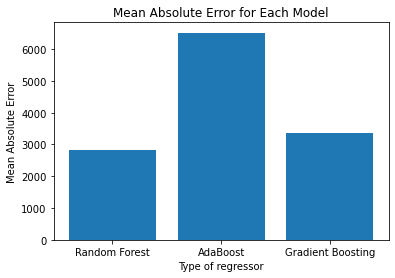

In [84]:
all_mae = [rand_for_mae, ab_mae, gb_mae]
fig,ax = plt.subplots()
adjsqr_bar = ax.bar(labels,all_mae)
ax.set_xlabel('Type of regressor')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Mean Absolute Error for Each Model')
plt.show()

Random forest had the best MAE score, with AdaBoost scoring the lowest.  This coincides fairly well with the RMSE.

The final graph that we will use for prediction is adjusted r squared, which generally is better at scoring at r squared because it takes into account the number of variables used.  Unlike RMSE and MAE, a higher score is considered better.

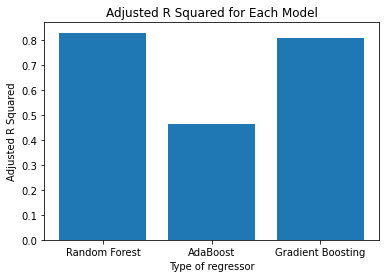

In [41]:
all_mae = [rand_for_adjrsq, ab_adjrsq, gb_adjrsq]
fig,ax = plt.subplots()
adjsqr_bar = ax.bar(labels,all_mae)
ax.set_xlabel('Type of regressor')
ax.set_ylabel('Adjusted R Squared')
ax.set_title('Adjusted R Squared for Each Model')
plt.show()

In [86]:
print(rand_for_adjrsq, gb_adjrsq)

0.8294034743837585 0.8062570680008994


Once again random forest scored the best, followed closely by gradient boosting.  It was so close that I wanted to look at the scores again.  AdaBoost was a much lower score, and taking into account that its time was worse than gradient boosting, so for this project, it can be eliminated as the best option.

The final question comes down to what model was the best performer for predicting vehicle price based on the variables given.  If I did not take into account time taken to make a prediction, Random Forest scored the best each time, but it was generally very close to gradient boosting.  However, when taking into account time, it took a more time, which could be a factor for large amounts of data.  This comes down to what is more important, accuracy or time?

Since this model is based on car predictions, and they are typically large investments, I am deciding that the less error is the most important factor in determining what model should go with price.  Therefore, Random Forest with the hyperparameters given is the best model.

I would note that random forest and gradient boosting are close enough that it could be worth testing out a wider variety of hyperparameters of each, if time permitted.